In [13]:
import torch
from torch import nn
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import rasterio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler


In [2]:
train_path = pathlib.Path("train")
train_images_path_list = list(train_path.glob("*/*.tif"))
train_label_path_list = list(train_path.glob("*/*.png"))
train_images_path_list, train_label_path_list

val_path = pathlib.Path("val")
val_images_path_list = list(val_path.glob("*/*.tif"))


In [3]:
def img_to_df(bands):
    df = pd.DataFrame()
    for band in range(bands.shape[0]):
        col_name = f"Band_{band+1}"
        all_pixels_band_val = []
        for i in range(bands.shape[1]):
            for j in range(bands.shape[2]):
                pixel_val = bands[band,i,j]
                all_pixels_band_val.append(pixel_val)
        df[col_name] = all_pixels_band_val
    return df

In [5]:
def transform_image():
    all_images_and_label = pd.DataFrame()
    for image,label in zip(train_images_path_list, train_label_path_list):
        print(image)
        print(label)
        with rasterio.open(image) as bands:
            image_bands = bands.read()
        with rasterio.open(label) as bands:
            label_bands = bands.read()
        bands_and_label_one_img = img_to_df(image_bands)
        bands_and_label_one_img['Label'] = img_to_df(label_bands)

        all_images_and_label = pd.concat([all_images_and_label,bands_and_label_one_img],ignore_index= True)

        

In [6]:
#all_images_and_label.to_csv("all_images_and_label.txt",index= False)
all_images_and_label = pd.read_csv("all_images_and_label.txt")


In [7]:
columns_name = ['Coastal aerosol','Blue','Green','Red','NIR','SWIR1','SWIR2','QA Band','Merit DEM','Copernicus DEM','ESA cover','Water prob','Class']

all_images_and_label.columns = columns_name

selected_bands = all_images_and_label[['Blue','Green','Red', 'NIR','SWIR1','SWIR2','Merit DEM','ESA cover','Water prob','Class']]


selected_bands = selected_bands.iloc[:163840,:]

In [8]:
class MinMaxNormalizer:
    def __init__(self, training_data):
        self.max = training_data.max()
        self.min = training_data.min()
    def normalize(self,data):
        return (data-self.min)/(self.max-self.min)
    def denormalize(self, data):
        return (data * (self.max - self.min) + self.min )

In [11]:
selected_bands_normalized = selected_bands

In [10]:
def calculate_water_indices(selected_bands_normalized):
    
    water_indices = pd.DataFrame()
    water_indices['NWDI'] = ((selected_bands_normalized['Green'] -selected_bands_normalized['NIR'])/ (selected_bands_normalized['Green'] + selected_bands_normalized['NIR']))
    water_indices['MNWDI'] = ((selected_bands_normalized['Green']- selected_bands_normalized['SWIR1'])/ (selected_bands_normalized['Green'] + selected_bands_normalized['SWIR1']))
    water_indices['WRI'] = ((selected_bands_normalized['Green'] + selected_bands_normalized['Red'])/ (selected_bands_normalized['NIR'] + selected_bands_normalized['SWIR1']))
    water_indices['AWEI'] = selected_bands_normalized['Blue'] + 2.5 * selected_bands_normalized['Green'] -1.5 * (selected_bands_normalized['NIR'] + selected_bands_normalized['SWIR1']) - 0.25 * selected_bands_normalized['SWIR2']

    return water_indices

In [11]:
water_indices = calculate_water_indices(selected_bands_normalized)
water_indices['Class'] = selected_bands['Class']


In [26]:
train_data, test_data = train_test_split(selected_bands, test_size= 0.3, random_state = 42)
train_data.head()

nor = MinMaxNormalizer(training_data=train_data)
print(nor.max)
print(nor.min)
normalized = nor.normalize(train_data)
train_data.head()


Blue          2099
Green         2517
Red           3522
NIR           6411
SWIR1         5147
SWIR2         5349
Merit DEM     1025
ESA cover       90
Water prob      97
Class            1
dtype: int64
Blue         -167
Green         -14
Red           -10
NIR          -131
SWIR1        -236
SWIR2        -199
Merit DEM      74
ESA cover      10
Water prob      0
Class           0
dtype: int64


,Blue,Green,Red,NIR,SWIR1,SWIR2,Merit DEM,ESA cover,Water prob,Class
89289,1258,1826,2266,2961,3802,3535,114,40,0,0
154561,467,849,1828,2562,3651,3187,485,30,0,0
18789,247,462,284,4155,1840,738,334,10,0,0
130686,870,1291,1814,2763,4106,3157,350,40,0,0
31788,131,301,173,3666,1777,618,360,10,0,0


In [42]:
train_data.shape[1]
train_data.iloc[:,train_data.shape[1]-1]

89289     0
154561    0
18789     0
130686    0
31788     0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: Class, Length: 114688, dtype: int64

In [43]:
#Creating datasets from DataFrame


class SatelliteImagery(Dataset):
    def __init__(self, train, test_size, df = selected_bands):
        super().__init__()
        train_data, test_data = train_test_split(df, test_size= test_size, random_state = 42)

        train_data.reset_index(drop = True, inplace = True)
        test_data.reset_index(drop = True, inplace = True)



        normalizer = MinMaxNormalizer(train_data)
        normalized_train_data = normalizer.normalize(train_data)
        normalized_test_data = normalizer.normalize(test_data)

        self.data = normalized_train_data if train else normalized_test_data
        
        self.inputs = self.data.iloc[:,0:self.data.shape[1]-1].values
        self.outputs = self.data.iloc[:,self.data.shape[1]-1].values
        
        '''
        scaler = MinMaxScaler()
        inputs_trans = scaler.transform(train_data.iloc[:,0:5].values)

        if train:
            self.inputs = inputs_trans
            self.outputs = self.data.iloc[:,5].values
        else:
            self.inputs = scaler.transform(self.data.iloc[:,0:5].values)
            self.outputs = self.data.iloc[:,5].values
        '''

        if len(self.inputs) != len(self.outputs):
            raise ValueError("The length of imput attributes and output label are different!")
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_features = self.inputs[idx]
        output_label = self.outputs[idx]
        return input_features.astype(np.float32),output_label.astype(np.float32)

In [44]:
train_dataloader = DataLoader(dataset= SatelliteImagery(train = True, test_size = 0.3), batch_size= 11468 , shuffle= True)
test_dataloader = DataLoader(dataset= SatelliteImagery(train= False, test_size= 0.3),batch_size= 4916, shuffle = True)

In [94]:
#Sample image
one_image_path = pathlib.Path("train/images/0.tif")
one_label_path = pathlib.Path("train/labels/0.png")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Satellite multiband image:


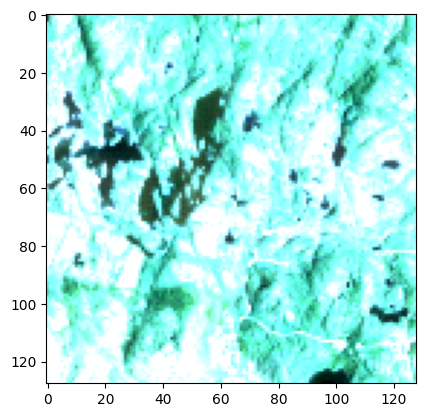

In [95]:
import rasterio

with rasterio.open(one_image_path) as src:
    bands = src.read()

print("Satellite multiband image:")
rgb_image = bands[1:4,:,:].transpose(2,1,0)
plt.imshow(rgb_image)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Satellite multiband image:


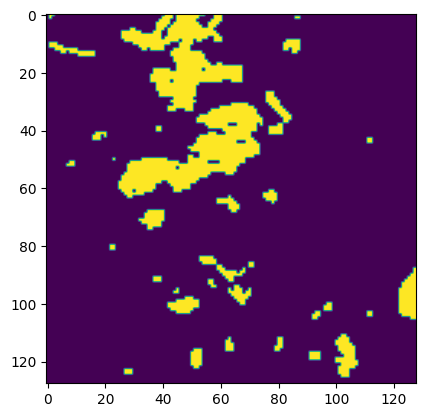

In [86]:
with rasterio.open(one_label_path) as src:
    label_bands = src.read()

print("Satellite multiband image:")
rgb_image = label_bands[0:1,:,:].transpose(1,2,0)
plt.imshow(rgb_image)

In [45]:
sample = next(iter(train_dataloader))

batch_input, batch_target = sample

batch_input.shape, batch_target.shape
batch_input



tensor([[0.2273, 0.2797, 0.1546,  ..., 0.2618, 0.2500, 0.0000],
        [0.1280, 0.1335, 0.0810,  ..., 0.1672, 0.0000, 0.0000],
        [0.2688, 0.3236, 0.4672,  ..., 0.4343, 0.2500, 0.0000],
        ...,
        [0.1708, 0.1995, 0.0968,  ..., 0.3512, 0.0000, 0.0000],
        [0.2754, 0.2750, 0.1857,  ..., 0.2587, 0.5000, 0.0000],
        [0.1862, 0.2015, 0.1260,  ..., 0.0452, 0.3750, 0.0000]])

In [47]:
# Creating Baseline Model

class ImageClassificationV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_features= input_shape, out_features= 1)



        )

    def forward(self, x):
        return self.net(x)

In [50]:
torch.manual_seed(42)
model_0 = ImageClassificationV0(input_shape= 4, output_shape=1)


In [45]:
a = model_0(batch_input)
a

tensor([[-0.4598],
        [-0.4302],
        [-0.4269],
        ...,
        [-0.4598],
        [-0.4520],
        [-0.4544]], grad_fn=<AddmmBackward0>)

In [58]:
c = a.squeeze()

In [62]:
sum(torch.sigmoid(c) > 0.5)



tensor(0)

In [52]:
b = model_0(batch_input)
b

tensor([[-0.8481],
        [-0.8141],
        [-0.7859],
        ...,
        [-0.9912],
        [-0.9696],
        [-0.2316]], grad_fn=<AddmmBackward0>)

In [53]:
torch.sigmoid(b)

tensor([[0.2998],
        [0.3070],
        [0.3131],
        ...,
        [0.2707],
        [0.2750],
        [0.4424]], grad_fn=<SigmoidBackward0>)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params= model_0.parameters(), lr= 0.001)

In [41]:
model_0.state_dict()

# Identify the dtype of each parameter
for param_name, param_tensor in model_0.state_dict().items():
    print(f"{param_name}: {param_tensor.dtype}")

net.0.weight: torch.float32
net.0.bias: torch.float32
net.2.weight: torch.float32
net.2.bias: torch.float32


In [19]:
def F1_Score(y_true, y_pred):
    true_positive = torch.sum((y_true == 1 ) & (y_pred == 1)).item()
    false_positive = torch.sum((y_true == 0 ) & (y_pred == 1)).item()
    false_negative = torch.sum((y_true == 1 ) & (y_pred == 0)).item()

        # Check if denominators are zero
    if true_positive + false_positive == 0:
        precision = 0.0
    else:
        precision = true_positive / (true_positive + false_positive)

    if true_positive + false_negative == 0:
        recall = 0.0
    else:
        recall = true_positive / (true_positive + false_negative)

    # Check if precision and recall are both zero
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)


    return f1_score

In [33]:
# Writing training loop
def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    
    train_loss, train_acc = 0,0
    model.train()
    #Adding a loop to loop through the training batches
    for X, y in data_loader:
        #Forward pass compuation
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits,y)

        train_loss += loss # Accumulate train loss for one epoch

        train_acc += accuracy_fn(y,y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Averaging total train loss over the epoch
    train_loss/= len(data_loader)
    train_acc/= len(data_loader)
    print(f"Train loss:{train_loss: .5f}|F1 score: {train_acc: .5f}")

In [34]:
def test_step(model: torch.nn.Module,
              
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    test_loss, test_acc = 0,0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X).squeeze()

            y_pred = torch.round(torch.sigmoid(y_logits))

            test_loss += loss_fn(y_logits, y)

            test_acc += accuracy_fn(y, y_pred)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss: .5f}| F1 score: {test_acc: .5f}")

In [35]:
def eval_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn
              ):
    loss, acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss += loss_fn(y_logits, y)

            acc += accuracy_fn(y, y_pred)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model name": model.__class__.__name__,
            "model_loss": loss.item(),
            "f1 score": acc}


In [42]:
epochs = 20

# Creatng a optimization and evaluation loop using train_step and test stpe

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n----------")

    train_step(model= model_0,
               data_loader=  train_dataloader,
               loss_fn= loss_fn,
               optimizer= optimizer,
               accuracy_fn= F1_Score)
    test_step(model=model_0,
              data_loader= test_dataloader, 
              loss_fn= loss_fn,
              accuracy_fn= F1_Score)
    
    

Epoch: 0
----------
Train loss: 0.56805|F1 score:  0.00000
Test loss:  0.57185| F1 score:  0.00000
Epoch: 1
----------
Train loss: 0.56767|F1 score:  0.00000
Test loss:  0.57061| F1 score:  0.00000
Epoch: 2
----------
Train loss: 0.57207|F1 score:  0.00000
Test loss:  0.56942| F1 score:  0.00000
Epoch: 3
----------
Train loss: 0.56539|F1 score:  0.00000
Test loss:  0.56819| F1 score:  0.00000
Epoch: 4
----------
Train loss: 0.56786|F1 score:  0.00000
Test loss:  0.56703| F1 score:  0.00000
Epoch: 5
----------
Train loss: 0.56771|F1 score:  0.00000
Test loss:  0.56587| F1 score:  0.00000
Epoch: 6
----------
Train loss: 0.56618|F1 score:  0.00000
Test loss:  0.56473| F1 score:  0.00000
Epoch: 7
----------
Train loss: 0.56465|F1 score:  0.00000
Test loss:  0.56359| F1 score:  0.00000
Epoch: 8
----------
Train loss: 0.56450|F1 score:  0.00000
Test loss:  0.56247| F1 score:  0.00000
Epoch: 9
----------
Train loss: 0.56744|F1 score:  0.00000
Test loss:  0.56140| F1 score:  0.00000
Epoch: 10


In [24]:
model_0_results = eval_step(model= model_0,
                            data_loader= test_dataloader,
                            accuracy_fn= F1_Score,
                            loss_fn= loss_fn)
model_0_results

{'model name': 'ImageClassificationV0',
 'model_loss': 0.20638331770896912,
 'f1 score': 0.5704159940290945}

In [72]:
# Addingg complexity to model
class ImageClassificationV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int
                 ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features= input_shape,out_features= hidden_units*2),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units*2,out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_shape),
            #nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)
    
model_1 = ImageClassificationV1(input_shape = 4, output_shape= 1, hidden_units= 4 )

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(),lr = 0.1)

In [74]:
# Creating optimization loop for model_1
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch +1}\n---------------")
    
    train_step(model= model_1,
               data_loader= train_dataloader,
               optimizer= optimizer,
               loss_fn= loss_fn,
               accuracy_fn= F1_Score)
    test_step(model= model_1,
              data_loader= test_dataloader,
              loss_fn= loss_fn,
              accuracy_fn= F1_Score)


Epoch: 1
---------------
Train loss: 0.34079|F1 score:  0.00000
Test loss:  0.33783| F1 score:  0.00000
Epoch: 2
---------------
Train loss: 0.31762|F1 score:  0.00000
Test loss:  0.33778| F1 score:  0.00000
Epoch: 3
---------------
Train loss: 0.34189|F1 score:  0.00000
Test loss:  0.33763| F1 score:  0.00000
Epoch: 4
---------------
Train loss: 0.34062|F1 score:  0.00000
Test loss:  0.33747| F1 score:  0.00000
Epoch: 5
---------------
Train loss: 0.31727|F1 score:  0.00000
Test loss:  0.33742| F1 score:  0.00000
Epoch: 6
---------------
Train loss: 0.31703|F1 score:  0.00000
Test loss:  0.33739| F1 score:  0.00000
Epoch: 7
---------------
Train loss: 0.31692|F1 score:  0.00000
Test loss:  0.33736| F1 score:  0.00000
Epoch: 8
---------------
Train loss: 0.34151|F1 score:  0.00000
Test loss:  0.33710| F1 score:  0.00000
Epoch: 9
---------------
Train loss: 0.36422|F1 score:  0.00000
Test loss:  0.33683| F1 score:  0.00000
Epoch: 10
---------------
Train loss: 0.31679|F1 score:  0.00000

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


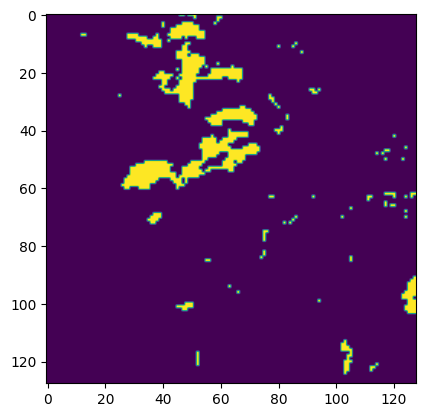

In [88]:
# Checking Images

with rasterio.open(train_images_path_list[0]) as bands:
    val_image = bands.read()
    img_val = img_to_df(val_image)
    img_val.columns = ['Coastal aerosol','Blue','Green','Red','NIR','SWIR1','SWIR2','QA Band','Merit DEM','Copernicus DEM','ESA cover','Water prob']

    img_val_selected = img_val[['Blue','Green','Red','NIR','SWIR1','SWIR2']]

    img_val_selected_norm = img_val_selected.apply(normalize_column)
    img_val_indices = calculate_water_indices(img_val_selected_norm)

img_val_tensor = torch.tensor(img_val_indices.values).to(torch.float32)

train_images_path_list[0]
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(img_val_tensor)
    y_pred = torch.round(torch.sigmoid(y_logits))

y_pred.shape

pred_img = y_pred.reshape(128,128)

#img = Image.fromarray((pred_img.numpy()).astype('uint8'),mode='1')

plt.imshow(pred_img)
 
 